# Boekenclassificatie

Aan jou de taak om een neuraal netwerk te bouwen dat zo goed mogelijk kan voorspellen in welk genre een sample van een boek zich bevind. Laat met een cross validation matrix zien hoe goed je model zich gedraagt per genre.

## 1. Business Understanding

- Data van [Project Gutenberg](https://www.gutenberg.org/)
- [Bibliotheek van Congress-classificatie](https://www.loc.gov/catdir/cpso/lcc.html)

## 1.1. Aangeleverde data


## 1.2. Genres
De boeken zijn ingedeeld onder de volgende zeven genres:
|Genre                                              |Engelse Vertaling                              |Aantal boeken
|---------------------------------------------------|-----------------------------------------------|-------------
|Amerikaanse Literatuur                             |American Literature                            |4480
|Engelse Literatuur                                 |English Literature                             |4214
|Fictie en jeugdliteratuur                          |Fiction and juvenile belles lettres            |2624
|Geschiedenis van Europa, Azië, Afrika en Oceanië   |History of Europa, Asia, Africa and Oceania    |2071
|Filosofie, Psychologie en Religie                  |Philosophy, Psychology and Religion            |1550
|Taal en Literatuur                                 |Language and Literature                        |1264
|Tijdschriften                                      |Periodicals                                    |1132

## 2. Data Understanding

### 2.1. Importeren van benodigde pakketten

In [64]:
from IPython.display import HTML, display
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

### 2.2. Inspecteren van `training.csv`

In [2]:
ROW_LIMIT = 60000
training_df = pd.read_csv("Data/huiswerk/training.csv.gz", nrows=ROW_LIMIT)

Om een eerste blik te werpen op de traindata, gebruik ik de volgende methodes. Ik zie dat er zo’n 120 duizend regels zijn, elk met:
- Een `usage`-veld, waarschijnlijk voor `training.csv` alleen maar `train`, voor `testing.csv` alleen maar `testing`, etc.
- Een `main genre`-veld, dat waarschijnlijk overeenkomt met de genres uit de Business Understanding
- Een `samplenumber`-veld, elk boek is gesplitst per 600 woorden, deze geeft aan wat eindpunt is van de genomen sample is
- Een `txt`-veld, met maximaal 600 woorden

In [3]:
training_df.info()
training_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   usage         60000 non-null  object
 1   main genre    60000 non-null  object
 2   title         60000 non-null  object
 3   samplenumber  60000 non-null  int64 
 4   txt           60000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


,usage,main genre,title,samplenumber,txt
0,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",600,journey more terrible than that of the ideal p...
1,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",1200,great struggle for freedom but a soldier of th...
2,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",1800,says overrun with superstition on one occasion...
3,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",2400,practice of swearing although previously he te...
4,train,American Literature,"The Works of John Greenleaf Whittier, Volume V...",3000,all manner of uncleanness he would laugh at al...


In verband met performance, pak ik eerst 20 duizend items, in plaats van de totale hoeveelheid.

In [4]:
# ROW_LIMIT = 20000
# training_df = training_df[ROW_LIMIT:]
# training_df

#### 2.2.1. `train`-veld
Het klopt inderdaad dat dit bestand alleen `train` als `usage` bevat:

In [4]:
unique_usages = [[x] for x in training_df['usage'].unique()]
pd.DataFrame(unique_usages, columns=['Usage'])

,Usage
0,train


#### 2.2.2. `main genre`-veld
Om te testen of de genres overeenkomen met de zeven uit de Business Understanding, pak ik de unieke genres van de dataframe, en zie dat ze inderdaad overeenkomen met de juiste uit de Business Understanding:

In [5]:
unieke_genres = training_df['main genre'].unique()
pd.DataFrame({'Genre': unieke_genres})

,Genre
0,American Literature
1,Fiction and juvenile belles lettres
2,Periodicals
3,English Literature
4,"Philosophy, Psychology and Religion"
5,"History of Europe, Asia, Africa and Oceania"
6,Language and Literature


#### 2.2.3. `txt`-veld
Het `txt`-veld bevat een deel van de tekst van een boek. Elk boek is namelijk gesplitst per 600 woorden, dus het veld bevat een deel van het boek. Zoals je je hieronder kunt zien, slaan de vijf zinnen los nergens op (althans het einde ervan), maar als je dan verderleest op de volgende regel, zul je zien dat het wél klopt:

In [6]:
for x in training_df['txt'].head():
    print('TXT: ' + x)

TXT: journey more terrible than that of the ideal pilgrim truth stranger than fiction the painful upward struggling of a spirit from the blackness of despair and blasphemy into the high pure air of hope and faith more earnest words were never written it is the entire unveiling of a human heart the tearing off of the fig leaf covering of its sin the voice which speaks to us from these old pages seems not so much that of a denizen of the world in which we live as of a soul at the last solemn confessional shorn of all ornament simple and direct as the contrition and prayer of childhood when for the first time the spectre of sin stands by its bedside the style is that of a man dead to self gratification careless of the worlds opinion and only desirous to convey to others in all truthfulness and sincerity the lesson of his inward trials temptations sins weaknesses and dangers and to give glory to him who had mercifully led him through all and enabled him like his own pilgrim to leave behind

Om een beeld te krijgen van het aantal tekens in het veld, pak ik de standaardafwijking, het minimum en maximum. Hier zie ik dat er een verschoven verdeling zit in het aantal tekens per `txt` veld:

In [7]:
txt_lengtes = training_df['txt'].apply(lambda txt: len(txt))
print(f"Standaardafwijking van het `txt`-veld is: {txt_lengtes.std()} tekens")
print(f"Gemiddelde van het `txt`-veld is: {txt_lengtes.mean()} tekens")
print(f"Met een minimum van {txt_lengtes.min()} teken(s)")
print(f"En een maximum van {txt_lengtes.max()} tekens")

Standaardafwijking van het `txt`-veld is: 192.52662024442674 tekens
Gemiddelde van het `txt`-veld is: 3200.6915 tekens
Met een minimum van 6 teken(s)
En een maximum van 4774 tekens


Omdat het aantal tekens wat verschoven is, vind ik het interessant om te kijken naar het aantal woorden per `txt`, waar ik zie dat het aantal woorden inderdaad rond de 600 zit, maar er toch een aantal regels zijn die niet zoveel bevatten:

In [8]:
training_df['woordaantal'] = training_df['txt'].apply(lambda txt: len(txt.split()))

In [9]:
txt_lengtes = training_df['woordaantal']
print(f"Standaardafwijking van het `txt`-veld is: {txt_lengtes.std()} woorden")
print(f"Gemiddelde van het `txt`-veld is: {txt_lengtes.mean()} tekens")
print(f"Met een minimum van {txt_lengtes.min()} woord(en)")
print(f"En een maximum van {txt_lengtes.max()} woorden")

Standaardafwijking van het `txt`-veld is: 14.254531021780787 woorden
Gemiddelde van het `txt`-veld is: 599.6211 tekens
Met een minimum van 1 woord(en)
En een maximum van 600 woorden


Hmm, het lijkt erop dat er een aantal regels zijn met weinig woorden, maar hoeveel zijn dat er? Hieronder zien we dat het grootste deel wel 600 woorden lang is, en maar $0.07 \%$ daaronder zit.

In [11]:
ranges = []
percentages = []
counts = []
for x in txt_lengtes.groupby(txt_lengtes // 100):
    percentage = (len(x[1]) / len(txt_lengtes) * 100)
    ranges.append(f'{x[0]}00-{x[0]+1}00')
    percentages.append(f"{percentage:2.2f}%")
    counts.append(len(x[1]))

pd.DataFrame({'Reeksen': ranges, 'Percentages': percentages, 'Aantallen': counts})

,Reeksen,Percentages,Aantallen
0,000-100,0.05%,28
1,100-200,0.02%,13
2,300-400,0.00%,2
3,400-500,0.00%,1
4,600-700,99.93%,59956


Om de tokenizer te kunnen laten werken in het model, is het belangrijk om het aantal verschillende woorden ongeveer te weten:

In [12]:
# tmp = set(itertools.chain.from_iterable(training_df['txt'].apply(lambda txt: txt.split())))
# len(tmp)

### 2.3. Inladen van `testing.csv` en `validation.csv`

In [10]:
testing_df = pd.read_csv("Data/huiswerk/testing.csv.gz", nrows=ROW_LIMIT)
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   usage         60000 non-null  object
 1   main genre    60000 non-null  object
 2   title         60000 non-null  object
 3   samplenumber  60000 non-null  int64 
 4   txt           60000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


In [11]:
validation_df = pd.read_csv("Data/huiswerk/validation.csv.gz", nrows=ROW_LIMIT)
validation_df = validation_df.head(ROW_LIMIT)
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   usage         60000 non-null  object
 1   main genre    60000 non-null  object
 2   title         60000 non-null  object
 3   samplenumber  60000 non-null  int64 
 4   txt           60000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


In [12]:
testing_df['woordaantal'] = testing_df['txt'].apply(lambda txt: len(txt.split()))

In [13]:
validation_df['woordaantal'] = validation_df['txt'].apply(lambda txt: len(txt.split()))

### 2.4. Dataset-balans
Ik zie dat er een onbalans zit in de dataset:

In [62]:
counts = training_df['main genre'].value_counts()

for x in range(len(counts)):
    counts[x] = f"{counts[x]} ({counts[x] / len(training_df) * 100:2.2f}%)"

counts

/var/folders/g_/05t9yvy52y731p3lghybrmbr0000gn/T/ipykernel_43922/38628450.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  counts[x] = f"{counts[x]} ({counts[x] / len(training_df) * 100:2.2f}%)"
/var/folders/g_/05t9yvy52y731p3lghybrmbr0000gn/T/ipykernel_43922/38628450.py:4: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  counts[x] = f"{counts[x]} ({counts[x] / len(training_df) * 100:2.2f}%)"
/var/folders/g_/05t9yvy52y731p3lghybrmbr0000gn/T/ipykernel_43922/38628450.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '19559 (32.62%)

main genre
English Literature                             19559 (32.62%)
American Literature                            13779 (22.98%)
History of Europe, Asia, Africa and Oceania     7289 (12.16%)
Fiction and juvenile belles lettres             6272 (10.46%)
Language and Literature                          5599 (9.34%)
Philosophy, Psychology and Religion              5214 (8.70%)
Periodicals                                      2244 (3.74%)
Name: count, dtype: object

## 3. Data Preparation

### 3.1. Filteren van teksten onder de 600 woorden
Zoals we zagen bij de Data Understanding, zijn de meeste teksten precies 600 woorden. Alles wat daaronder zit is een miniscule hoeveelheid, en filter ik daarom gewoon weg.

In [14]:
AANTAL_WOORDEN_PER_TEKST = 600
training_df = training_df[training_df['woordaantal'] == AANTAL_WOORDEN_PER_TEKST]
training_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59956 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   usage         59956 non-null  object
 1   main genre    59956 non-null  object
 2   title         59956 non-null  object
 3   samplenumber  59956 non-null  int64 
 4   txt           59956 non-null  object
 5   woordaantal   59956 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ MB


In [15]:
testing_df = testing_df[testing_df['woordaantal'] == AANTAL_WOORDEN_PER_TEKST]
validation_df = validation_df[validation_df['woordaantal'] == AANTAL_WOORDEN_PER_TEKST]

### 3.2. Balanceren van de dataset

In [67]:
class_weights = compute_class_weight('balanced', classes=unieke_genres, y=training_df['main genre'])
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.6216084517848071,
 1: 1.365615889212828,
 2: 3.816908581614464,
 3: 0.43791312731442594,
 4: 1.642720149049263,
 5: 1.175077906042373,
 6: 1.529762967876917}

### 3.2. Omzetten labels
Om te kunnen werken met getallen bij de labels, gebruik ik de [`LabelEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) van _scikit-learn_:

In [16]:
le = LabelEncoder()
le.fit(unieke_genres)
LABEL_COUNT = len(unieke_genres)

train_labels = le.transform(training_df['main genre'])
testing_labels = le.transform(testing_df['main genre'])
validation_labels = le.transform(validation_df['main genre'])

### 3.2. Opzetten tokenizer

In [17]:
# AANTAL_WOORDEN = 200000
AANTAL_WOORDEN = 10000
tokenizer = Tokenizer(num_words=AANTAL_WOORDEN)
tokenizer.fit_on_texts(training_df['txt'])

In [21]:
list(tokenizer.word_index.items())[:5]

[('the', 1), ('and', 2), ('of', 3), ('to', 4), ('a', 5)]

In [18]:
import gc
gc.collect(2)

0

In [19]:
train_sequences = tokenizer.texts_to_sequences(training_df['txt'])
testing_sequences = tokenizer.texts_to_sequences(testing_df['txt'])
validation_sequences = tokenizer.texts_to_sequences(validation_df['txt'])

In [20]:
AANTAL_WOORDEN_PER_TEKST = 600
train_sequences = keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=AANTAL_WOORDEN_PER_TEKST)
testing_sequences = keras.preprocessing.sequence.pad_sequences(testing_sequences, maxlen=AANTAL_WOORDEN_PER_TEKST)
validation_sequences = keras.preprocessing.sequence.pad_sequences(validation_sequences, maxlen=AANTAL_WOORDEN_PER_TEKST)

In [25]:
del percentage
del percentages
del ranges
del txt_lengtes
del unieke_genres
del unique_usages
del x
del testing_df
# del tmp
del training_df
del validation_df


## 4. Modeling

In [24]:
DIMS=50
model = models.Sequential([
    layers.Embedding(input_dim=AANTAL_WOORDEN, output_dim=DIMS, input_length=AANTAL_WOORDEN_PER_TEKST),
    layers.Bidirectional(layers.GRU(32, return_sequences=True, dropout=0.2)),
    layers.Bidirectional(layers.GRU(32)),
    # layers.LSTM(32),
    layers.Dense(LABEL_COUNT, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
with tf.device("/cpu:0"):
# try:
    history = model.fit(train_sequences,
                        train_labels,
                         validation_data=(validation_sequences, validation_labels),
                         epochs=3)
# except Exception as e:
#     # TensorFlow is zo achterlijk om de VOLLEDIGE dataset te printen, waardoor VS Code en Python vastlopen
#     print("Gefaald: ")
#     raise Exception("Gefaald")

Epoch 1/3


2024-10-06 13:09:57.819251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1874/1874 ━━━━━━━━━━━━━━━━━━━━ 474s 252ms/step - accuracy: 0.3981 - loss: 1.5244 - val_accuracy: 0.4748 - val_loss: 1.4600
Epoch 2/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 471s 251ms/step - accuracy: 0.7378 - loss: 0.7744 - val_accuracy: 0.5339 - val_loss: 1.4836
Epoch 3/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 470s 251ms/step - accuracy: 0.8449 - loss: 0.4681 - val_accuracy: 0.5404 - val_loss: 1.5295


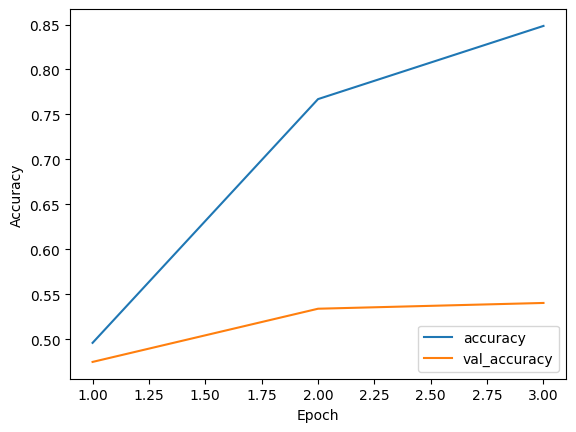

In [25]:
#plot de accuracy en validated accuracy
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [41]:
DIMS=100 # <--
model = models.Sequential([
    layers.Embedding(input_dim=AANTAL_WOORDEN, output_dim=DIMS, input_length=AANTAL_WOORDEN_PER_TEKST),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(LABEL_COUNT, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 236s 125ms/step - accuracy: 0.3393 - loss: 1.6703 - val_accuracy: 0.3281 - val_loss: 1.6716
Epoch 2/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 236s 126ms/step - accuracy: 0.4075 - loss: 1.4228 - val_accuracy: 0.4233 - val_loss: 1.5751
Epoch 3/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 236s 126ms/step - accuracy: 0.6352 - loss: 0.9760 - val_accuracy: 0.4825 - val_loss: 1.4887


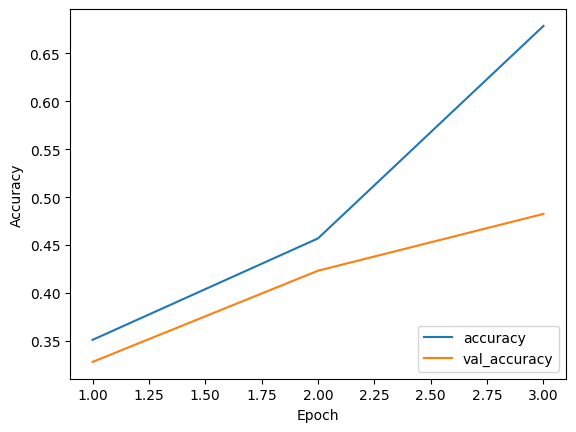

In [42]:
with tf.device("/cpu:0"):
    history2 = model.fit(train_sequences,
                        train_labels,
                         validation_data=(validation_sequences, validation_labels),
                         epochs=3)

acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [43]:
DIMS=150 # <--
model = models.Sequential([
    layers.Embedding(input_dim=AANTAL_WOORDEN, output_dim=DIMS, input_length=AANTAL_WOORDEN_PER_TEKST),
    layers.Bidirectional(layers.GRU(32, return_sequences=True, dropout=0.2)),
    layers.Bidirectional(layers.GRU(32, return_sequences=True, dropout=0.2)),
    layers.Bidirectional(layers.GRU(32, return_sequences=True, dropout=0.2)),
    layers.Bidirectional(layers.GRU(32)),
    layers.Dense(LABEL_COUNT, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_22                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_24                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1017s 541ms/step - accuracy: 0.4141 - loss: 1.4807 - val_accuracy: 0.4984 - val_loss: 1.4559
Epoch 2/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 1007s 537ms/step - accuracy: 0.7946 - loss: 0.6356 - val_accuracy: 0.4931 - val_loss: 1.6044
Epoch 3/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 999s 533ms/step - accuracy: 0.8529 - loss: 0.4586 - val_accuracy: 0.5234 - val_loss: 1.5513


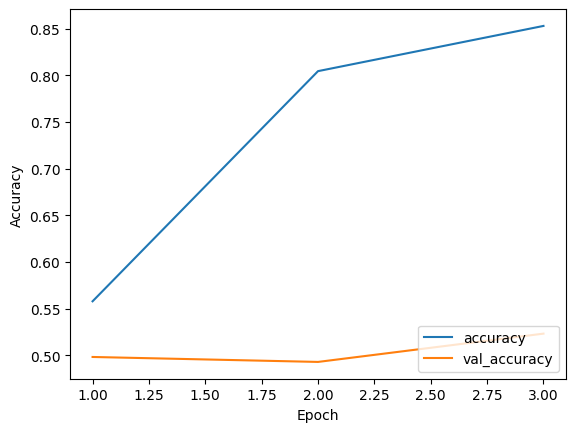

In [44]:
with tf.device("/cpu:0"):
    history2 = model.fit(train_sequences,
                        train_labels,
                         validation_data=(validation_sequences, validation_labels),
                         epochs=3)

acc=history2.history['accuracy']
val_acc=history2.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 335s 179ms/step


<Axes: >

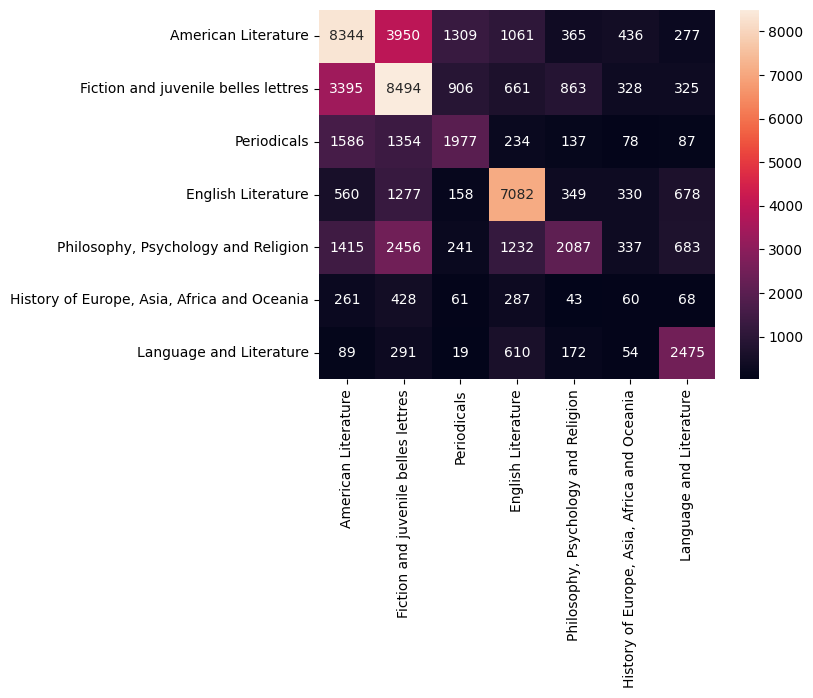

In [49]:
Y_predict = []
predict = model.predict(testing_sequences)
for i in range(len(predict)):
    Y_predict.append(predict[i].argmax())

cm = confusion_matrix(testing_labels, Y_predict)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=unieke_genres, yticklabels=unieke_genres)

### 4.x. Balanced dataset

/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 238s 126ms/step - accuracy: 0.2642 - loss: 2.1951 - val_accuracy: 0.2590 - val_loss: 1.8362
Epoch 2/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 235s 125ms/step - accuracy: 0.3646 - loss: 1.8259 - val_accuracy: 0.3154 - val_loss: 1.7951
Epoch 3/3
1874/1874 ━━━━━━━━━━━━━━━━━━━━ 235s 125ms/step - accuracy: 0.4119 - loss: 1.7019 - val_accuracy: 0.3187 - val_loss: 1.7256


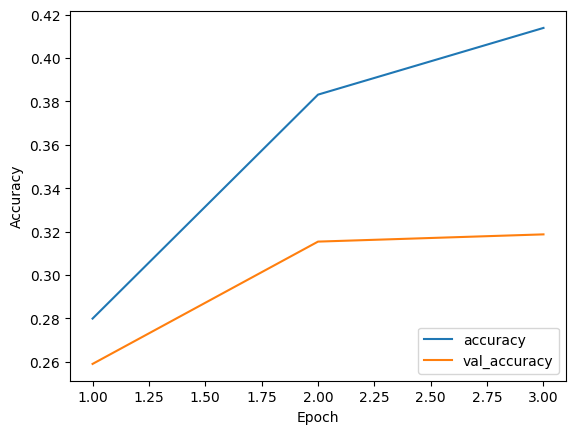

In [68]:
DIMS=100
model = models.Sequential([
    layers.Embedding(input_dim=AANTAL_WOORDEN, output_dim=DIMS, input_length=AANTAL_WOORDEN_PER_TEKST),
    layers.LSTM(32, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(LABEL_COUNT, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

with tf.device("/cpu:0"):
    history3 = model.fit(train_sequences,
                         train_labels,
                         class_weight=class_weights_dict,
                         validation_data=(validation_sequences, validation_labels),
                         epochs=3)

acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 54s 29ms/step


<Axes: >

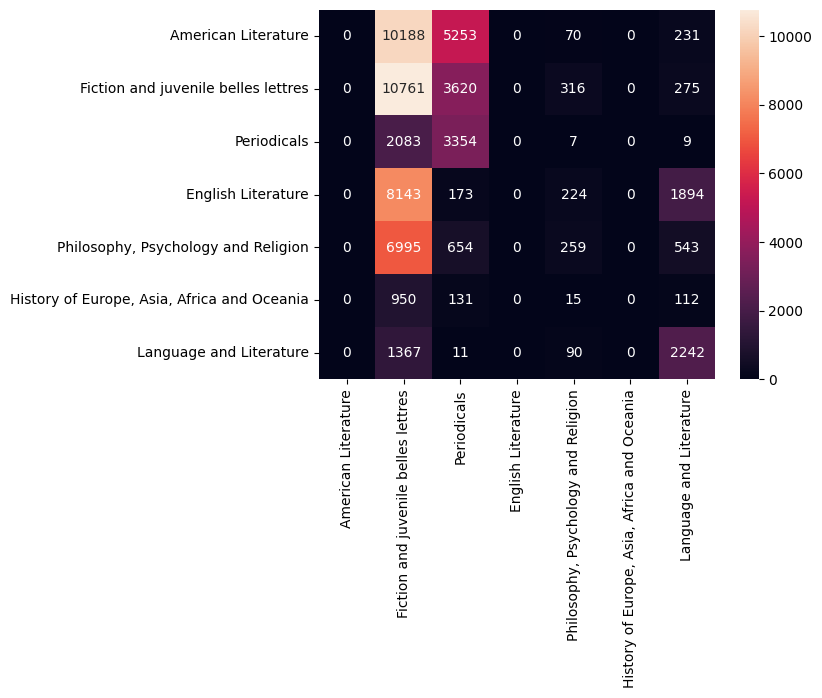

In [69]:
Y_predict = []
predict = model.predict(testing_sequences)
for i in range(len(predict)):
    Y_predict.append(predict[i].argmax())

cm = confusion_matrix(testing_labels, Y_predict)
sns.heatmap(cm, annot=True, fmt='g', xticklabels=unieke_genres, yticklabels=unieke_genres)

### 4.x. Conv1D-laag

In [ ]:
DIMS=100
model = models.Sequential([
    layers.Embedding(input_dim=AANTAL_WOORDEN, output_dim=DIMS, input_length=AANTAL_WOORDEN_PER_TEKST),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(32),
    layers.Dense(LABEL_COUNT, activation='sigmoid'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

with tf.device("/cpu:0"):
    history3 = model.fit(train_sequences,
                         train_labels,
                         class_weight=class_weights_dict,
                         validation_data=(validation_sequences, validation_labels),
                         epochs=3)

acc=history3.history['accuracy']
val_acc=history3.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Epoch 1/3


/opt/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1207/1874 ━━━━━━━━━━━━━━━━━━━━ 45s 68ms/step - accuracy: 0.3061 - loss: 2.0838

## 5. Evaluation

## 6. Deployment